着順を予想

https://agusblog.net/keiba-ai-data-encode/    
https://agusblog.net/keiba-ai-model-learning/    

インストールが必要したモジュール

    conda install -c conda-forge scikit-learn (conda-forgeは、intelでも可)
    conda install -c conda-forge scipy
    conda install -c conda-forge lightgbm

# モジュール

In [149]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scipy.stats
import sys
import zipfile

import lightgbm as lgb
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot  as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import date, datetime, timedelta
from sklearn import metrics

# パラメータ

In [150]:
infile = "./data/netkeiba_2020-2024.zip"
infile2 = "./data/2024_add.csv"

# モデルの学習／検証の対象レース
valid_ymd = "20240323"
valid_race = "第72回日経賞(G2)"

# データの取得

In [151]:
# zipファイルは展開してループ
zip_f = zipfile.ZipFile(infile)
file_list = zip_f.namelist()

_df_list = []
for file in file_list:
    _df = pd.read_csv(zip_f.open(file),encoding="shift-jis")#,parse_dates=['日付'])
    print(file.encode('cp437').decode('cp437'), _df.shape)
    _df_list.append(_df)

_df = pd.read_csv(infile2,encoding="shift-jis")#,parse_dates=['日付'])
print(infile2, _df.shape)
_df_list.append(_df)

df = pd.concat(_df_list)

netkeiba_2020-2024/2020.csv (48282, 26)
netkeiba_2020-2024/2021.csv (47821, 26)
netkeiba_2020-2024/2022.csv (47220, 26)
netkeiba_2020-2024/2023.csv (47672, 26)
netkeiba_2020-2024/2024.csv (9024, 26)
./data/2024_add.csv (10, 26)


In [152]:
# ck
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200029 entries, 0 to 9
Data columns (total 26 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   race_id  200029 non-null  int64  
 1   馬        200029 non-null  object 
 2   騎手       200029 non-null  object 
 3   馬番       200029 non-null  int64  
 4   走破時間     198429 non-null  object 
 5   オッズ      200029 non-null  object 
 6   通過順      199073 non-null  object 
 7   着順       200019 non-null  object 
 8   体重       200019 non-null  float64
 9   体重変化     200019 non-null  float64
 10  性        200029 non-null  object 
 11  齢        200029 non-null  int64  
 12  斤量       200029 non-null  float64
 13  上がり      198429 non-null  float64
 14  人気       199335 non-null  float64
 15  レース名     200029 non-null  object 
 16  日付       200029 non-null  object 
 17  開催       200029 non-null  object 
 18  クラス      200029 non-null  object 
 19  芝・ダート    200029 non-null  object 
 20  距離       200029 non-null  int64  
 2

# 前処理

## 変数の絞り込み

In [153]:
# df = df[["race_id","馬","馬番","走破時間","着順","芝・ダート","距離","日付","レース名"]]

In [154]:
# # ck
# df.head(3)

In [155]:
def class_mapping(row):
    mappings = {'障害':0, 'G1': 10, 'G2': 9, 'G3': 8, '(L)': 7, 'オープン': 7,'OP': 7, '3勝': 6, '1600': 6, '2勝': 5, '1000': 5, '1勝': 4, '500': 4, '新馬': 3, '未勝利': 1}
    for key, value in mappings.items():
        if key in row:
            return value
    return 0  # If no mapping is found, return 0

df['クラス'] = df['クラス'].apply(class_mapping)          
sex_mapping = {'牡':0, '牝': 1, 'セ': 2}
df['性'] = df['性'].map(sex_mapping)
shiba_mapping = {'芝': 0, 'ダ': 1, '障': 2}
df['芝・ダート'] = df['芝・ダート'].map(shiba_mapping)
mawari_mapping = {'右': 0, '左': 1, '芝': 2, '直': 2}
df['回り'] = df['回り'].map(mawari_mapping)
baba_mapping = {'良': 0, '稍': 1, '重': 2, '不': 3}
df['馬場'] = df['馬場'].map(baba_mapping)
tenki_mapping = {'晴': 0, '曇': 1, '小': 2, '雨': 3, '雪': 4}
df['天気'] = df['天気'].map(tenki_mapping)

## 走破時間を数値に変換

In [156]:
# 既存のコード：走破時間を秒に変換
time_parts = df['走破時間'].str.split(':', expand=True) # 「：」前後で分と秒を分割
seconds = (
    time_parts[0].astype(float) * 60 + 
    time_parts[1].str.split('.', expand=True)[0].astype(float) + 
    time_parts[1].str.split('.', expand=True)[1].astype(float) / 10
)
df.rename(columns={'走破時間':'走破時間_org'},inplace=True) # 元データを退避
df['走破時間'] = seconds

In [157]:
# ck 
df[["走破時間_org","走破時間"]].head(3)

,走破時間_org,走破時間
0,1:49.7,109.7
1,1:50.0,110.0
2,1:50.1,110.1


## レース番号を取得

In [158]:
# レースだけを特定する場合は、末尾2桁を使用
df['レース番号'] = df['race_id'].astype(str).str[-2:].astype(int)

In [159]:
# ck 
pd.concat([
    df[["race_id","レース番号"]].head(1),
    df[["race_id","レース番号"]].tail(1)
])  

,race_id,レース番号
0,202001010101,1
9,202406030111,11


## 直近までの日数差を算出

In [160]:
# 文字列を日付型に変換し予測レースまでの日数差を算出
df.rename(columns={'日付':'日付_org'},inplace=True) # 元データを退避
df["日付"] = pd.to_datetime(df["日付_org"], format="%Y年%m月%d日")
df["日数差"] = df["日付"] - datetime.strptime(valid_ymd, '%Y%m%d')
df["日数差"] = -(df["日数差"] / timedelta(days=1)) # 日数差はtimedelta型なので整数で扱えるようにtimedelta(days=1)で割る

In [161]:
# ck 
print(f"{valid_ymd}までの日数差")
pd.concat([
    df[["日付_org","日付","日数差"]].head(1),
    df[["日付_org","日付","日数差"]].tail(1)
])

20240323までの日数差


,日付_org,日付,日数差
0,2020年7月25日,2020-07-25,1337.0
9,2024年3月23日,2024-03-23,-0.0


## 同じ馬の過去5レースの情報を新しいレース結果にマージ

In [162]:
# '馬'と'日付'に基づいて降順にソート
df.sort_values(by=['馬', '日付'], ascending=[True, False], inplace=True)
df["着順"]

# 同じ馬の過去5レースの情報を新しいレース結果にマージ
features = ['馬番', '騎手', '斤量', '体重', '体重変化', '上がり', '距離', 'クラス', '走破時間', '芝・ダート', '天気','馬場','日数差']
for i in range(1, 6):
    for feature in features:
        df[f'{feature}{i}'] = df.groupby('馬')[feature].shift(-i)


In [163]:
# 斤量に関連する列を数値に変換し、変換できないデータはNaNにします。
kinryo_columns = ['斤量', '斤量1', '斤量2', '斤量3', '斤量4','斤量5']
for col in kinryo_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 平均斤量を計算します。
df['平均斤量'] = df[kinryo_columns].mean(axis=1)

In [164]:
# # 騎手の勝率
# jockey_win_rate = df.groupby('騎手')['着順'].apply(lambda x: (x==1).sum() / x.count()).reset_index()
# jockey_win_rate.columns = ['騎手', '騎手の勝率']
# jockey_win_rate.to_csv('calc_rate/jockey_win_rate.csv', index=False)
# # '騎手'をキーにしてdf_combinedとjockey_win_rateをマージする
# df = pd.merge(df_combined, jockey_win_rate, on='騎手', how='left')

In [165]:
# ck
df.head(3)

,race_id,馬,騎手,馬番,走破時間_org,オッズ,通過順,着順,体重,体重変化,...,体重変化5,上がり5,距離5,クラス5,走破時間5,芝・ダート5,天気5,馬場5,日数差5,平均斤量
7835,202410020201,アアル,小沢大仁,6,1:54.9,209.6,11-13-15-15,15,482.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0
17689,202305040704,アアル,菅原明良,5,1:30.7,14.7,10-12,14,470.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0
47115,202110040408,アイアイテーラー,鮫島良太,7,1:50.3,79.6,3-3-15-16,16,460.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.5


## カテゴリ変数をダミー変数化

In [166]:
categorical_features = ['馬','芝・ダート','芝・ダート1','芝・ダート2','芝・ダート3','芝・ダート4','芝・ダート5','騎手','騎手1','騎手2','騎手3','騎手4','騎手5']

for c in categorical_features:
    le = LabelEncoder()
    le.fit(df[c])
    df[c] = le.transform(df[c])

In [167]:
# ck
df.head(3)

,race_id,馬,騎手,馬番,走破時間_org,オッズ,通過順,着順,体重,体重変化,...,体重変化5,上がり5,距離5,クラス5,走破時間5,芝・ダート5,天気5,馬場5,日数差5,平均斤量
7835,202410020201,0,111,6,1:54.9,209.6,11-13-15-15,15,482.0,12.0,...,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,56.0
17689,202305040704,0,239,5,1:30.7,14.7,10-12,14,470.0,0.0,...,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,56.0
47115,202110040408,1,282,7,1:50.3,79.6,3-3-15-16,16,460.0,0.0,...,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,54.5


# 学習

## 目的変数を作成

In [168]:
# '着順'カラムの値を数値に変換しようとして、エラーが発生する場合はNaNにする
df.rename(columns={"着順":"着順_org"},inplace=True)
df['着順'] = pd.to_numeric(df['着順_org'], errors='coerce')

# 上位３位に1立て
df['target'] = df['着順'].map(lambda x: 1 if x<4 else 0)

In [169]:
# ck
df.groupby(["target"]).agg({
    "race_id": "count",
    "着順":["min","max"]
})

race_id   着順      
         count  min   max
target                   
0       156583  4.0  18.0
1        43446  1.0   3.0

## 学習／検証データに分割

In [194]:
# 予測レースよりも過去のデータを取得
tg_df = df[df["日付"] < datetime.strptime(valid_ymd, '%Y%m%d')]

# 特徴量とターゲットの分割
train_df, test_df = train_test_split(tg_df, test_size=0.3, random_state=1234)

drop_vars = ['race_id','target','走破時間_org','着順_org','日付_org','走破時間','日付',"日数差","レース名",'通過順',
 '着順',
 '体重',
 '体重変化',
'人気',
'上がり',
'場名',
'開催',
            "オッズ",]
X_train = train_df.drop(drop_vars, axis=1)
y_train = train_df['target']
X_test = test_df.drop(drop_vars, axis=1)
y_test = test_df['target']

In [195]:
# ck
tg_df.agg({"日付":["min","max"]})

,日付
min,2020-01-05
max,2024-03-03


In [196]:
# ck
print(f"tg_df   :{len(tg_df)}")
print(f"train_df:{len(train_df)}")
print(f"test_df :{len(test_df)}")

tg_df   :200019
train_df:140013
test_df :60006


In [197]:
# ck
print(X_train.columns.tolist())

['馬', '騎手', '馬番', '性', '齢', '斤量', 'クラス', '芝・ダート', '距離', '回り', '馬場', '天気', '場id', 'レース番号', '馬番1', '騎手1', '斤量1', '体重1', '体重変化1', '上がり1', '距離1', 'クラス1', '走破時間1', '芝・ダート1', '天気1', '馬場1', '日数差1', '馬番2', '騎手2', '斤量2', '体重2', '体重変化2', '上がり2', '距離2', 'クラス2', '走破時間2', '芝・ダート2', '天気2', '馬場2', '日数差2', '馬番3', '騎手3', '斤量3', '体重3', '体重変化3', '上がり3', '距離3', 'クラス3', '走破時間3', '芝・ダート3', '天気3', '馬場3', '日数差3', '馬番4', '騎手4', '斤量4', '体重4', '体重変化4', '上がり4', '距離4', 'クラス4', '走破時間4', '芝・ダート4', '天気4', '馬場4', '日数差4', '馬番5', '騎手5', '斤量5', '体重5', '体重変化5', '上がり5', '距離5', 'クラス5', '走破時間5', '芝・ダート5', '天気5', '馬場5', '日数差5', '平均斤量']


## 勾配ブースティング

In [198]:
params={
    'num_leaves':50,
    # 'n_estimators':80,
    # 'min_data_in_leaf':190,
    'class_weight':'balanced',
    'random_state':100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train, y_train)
y_pred_train = lgb_clf.predict_proba(X_train)[:,1]
y_pred = lgb_clf.predict_proba(X_test)[:,1]

print(roc_auc_score(y_test,y_pred))
print(roc_auc_score(y_train,y_pred_train))

[LightGBM] [Info] Number of positive: 30440, number of negative: 109573
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 140013, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.715491033598241
0.7741151470216132


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AUC: 0.7154910335982412


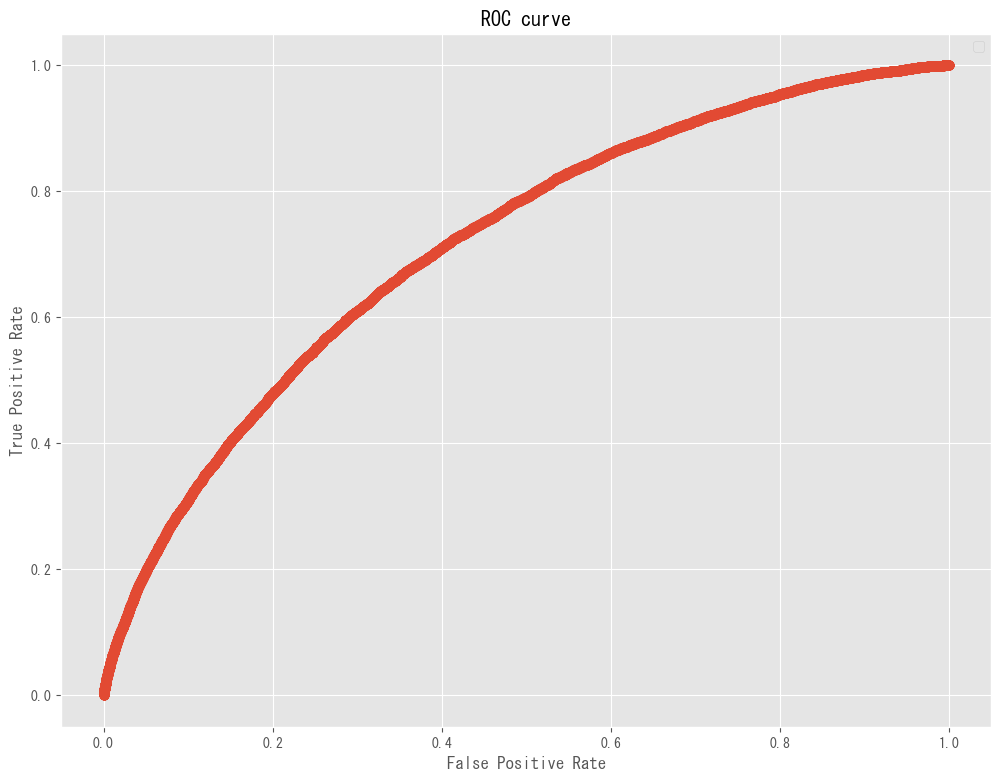

In [199]:
# テストデータを予測する
y_pred = lgb_clf.predict_proba(X_test)[:,1]

# AUCを計算
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, drop_intermediate=False, )
print('AUC:', metrics.auc(fpr, tpr))

# ROC曲線をプロット
plt.plot(fpr, tpr, marker='o')
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# 変数重要度を出力

In [200]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12,9]
plt.rcParams['font.family'] = 'MS Gothic'

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

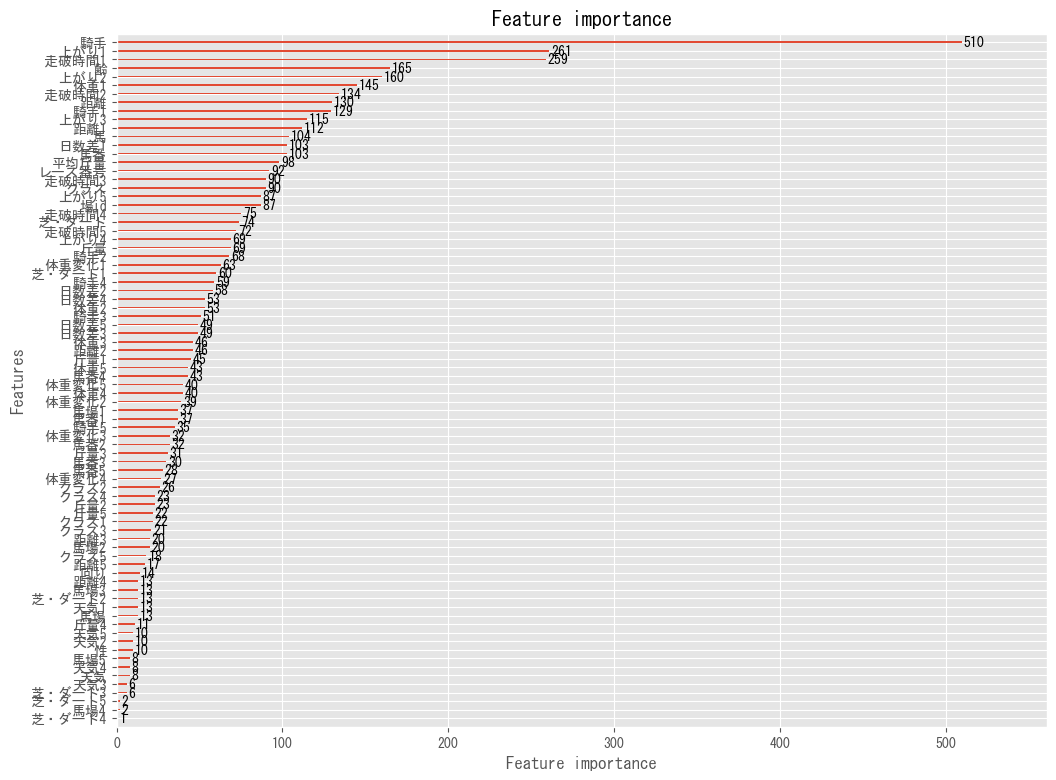

In [201]:
# 特徴量の重要度を棒グラフで可視化
lgb.plot_importance(lgb_clf)

## 予測

In [202]:
# 予測レースよりも過去のデータを取得
valid_df = df[
    (df["日付"] == datetime.strptime(valid_ymd, '%Y%m%d')) & 
    (df["レース名"] == valid_race)
]

In [203]:
# ck
valid_df[["日付","レース名","レース番号","馬番"]].sort_values(["馬番"]).head(20)

,日付,レース名,レース番号,馬番
0,2024-03-23,第72回日経賞(G2),11,1
1,2024-03-23,第72回日経賞(G2),11,2
2,2024-03-23,第72回日経賞(G2),11,3
3,2024-03-23,第72回日経賞(G2),11,4
4,2024-03-23,第72回日経賞(G2),11,5
5,2024-03-23,第72回日経賞(G2),11,6
6,2024-03-23,第72回日経賞(G2),11,7
7,2024-03-23,第72回日経賞(G2),11,8
8,2024-03-23,第72回日経賞(G2),11,9
9,2024-03-23,第72回日経賞(G2),11,10


In [205]:
# 予測
drop_vars = ['race_id','target','走破時間_org','着順_org','日付_org','走破時間','日付',"日数差","レース名",'通過順',
 '人気',
 '着順',
 '体重',
 '体重変化',
'上がり',
'場名',
'開催',
            "オッズ",]
X_valid = valid_df.drop(drop_vars, axis=1)
y_pred_valid = lgb_clf.predict_proba(X_valid)[:,1]
valid_df["pred"] = y_pred_valid

C:\Users\petbo\AppData\Local\Temp\ipykernel_25576\2039437403.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["pred"] = y_pred_valid


In [206]:
# ck
valid_df[["日付","レース名","レース番号","馬番","馬","着順","pred"]].sort_values(["pred"],ascending=False).head(20)

,日付,レース名,レース番号,馬番,馬,着順,pred
5,2024-03-23,第72回日経賞(G2),11,6,9376,NaN,0.521277
3,2024-03-23,第72回日経賞(G2),11,4,7959,NaN,0.463860
9,2024-03-23,第72回日経賞(G2),11,10,6136,NaN,0.448119
1,2024-03-23,第72回日経賞(G2),11,2,21125,NaN,0.431413
8,2024-03-23,第72回日経賞(G2),11,9,20357,NaN,0.283008
7,2024-03-23,第72回日経賞(G2),11,8,754,NaN,0.282427
0,2024-03-23,第72回日経賞(G2),11,1,17419,NaN,0.280693
2,2024-03-23,第72回日経賞(G2),11,3,20215,NaN,0.246343
4,2024-03-23,第72回日経賞(G2),11,5,20629,NaN,0.243142
6,2024-03-23,第72回日経賞(G2),11,7,2184,NaN,0.180928


全然違う・・・